# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4980736/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:38 - loss: 0.6942

  30/1875 [..............................] - ETA: 3s - loss: 0.5521   

  66/1875 [>.............................] - ETA: 2s - loss: 0.4595

  99/1875 [>.............................] - ETA: 2s - loss: 0.4177

 130/1875 [=>............................] - ETA: 2s - loss: 0.3923

 161/1875 [=>............................] - ETA: 2s - loss: 0.3735

 192/1875 [==>...........................] - ETA: 2s - loss: 0.3586

 221/1875 [==>...........................] - ETA: 2s - loss: 0.3470

 249/1875 [==>...........................] - ETA: 2s - loss: 0.3374

 279/1875 [===>..........................] - ETA: 2s - loss: 0.3283

 309/1875 [===>..........................] - ETA: 2s - loss: 0.3204

 342/1875 [====>.........................] - ETA: 2s - loss: 0.3127

 373/1875 [====>.........................] - ETA: 2s - loss: 0.3062

 409/1875 [=====>........................] - ETA: 2s - loss: 0.2994

 440/1875 [======>.......................] - ETA: 2s - loss: 0.2941

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2893

 504/1875 [=======>......................] - ETA: 2s - loss: 0.2844

 535/1875 [=======>......................] - ETA: 2s - loss: 0.2802

 567/1875 [========>.....................] - ETA: 2s - loss: 0.2762

 598/1875 [========>.....................] - ETA: 2s - loss: 0.2725

 629/1875 [=========>....................] - ETA: 2s - loss: 0.2690

 659/1875 [=========>....................] - ETA: 1s - loss: 0.2659

 689/1875 [==========>...................] - ETA: 1s - loss: 0.2629

 718/1875 [==========>...................] - ETA: 1s - loss: 0.2602

 748/1875 [==========>...................] - ETA: 1s - loss: 0.2575

 777/1875 [===========>..................] - ETA: 1s - loss: 0.2550

 807/1875 [===========>..................] - ETA: 1s - loss: 0.2526

 834/1875 [============>.................] - ETA: 1s - loss: 0.2505

 857/1875 [============>.................] - ETA: 1s - loss: 0.2487

 885/1875 [=============>................] - ETA: 1s - loss: 0.2467

 914/1875 [=============>................] - ETA: 1s - loss: 0.2447

 943/1875 [==============>...............] - ETA: 1s - loss: 0.2427

 971/1875 [==============>...............] - ETA: 1s - loss: 0.2409

1000/1875 [===============>..............] - ETA: 1s - loss: 0.2390

1031/1875 [===============>..............] - ETA: 1s - loss: 0.2372

1061/1875 [===============>..............] - ETA: 1s - loss: 0.2354

1091/1875 [================>.............] - ETA: 1s - loss: 0.2337

1120/1875 [================>.............] - ETA: 1s - loss: 0.2321

1150/1875 [=================>............] - ETA: 1s - loss: 0.2305

1180/1875 [=================>............] - ETA: 1s - loss: 0.2290

1209/1875 [==================>...........] - ETA: 1s - loss: 0.2276

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2262

1267/1875 [===================>..........] - ETA: 1s - loss: 0.2248

1298/1875 [===================>..........] - ETA: 0s - loss: 0.2234

1329/1875 [====================>.........] - ETA: 0s - loss: 0.2220

1358/1875 [====================>.........] - ETA: 0s - loss: 0.2208

1381/1875 [=====================>........] - ETA: 0s - loss: 0.2198

1408/1875 [=====================>........] - ETA: 0s - loss: 0.2187

1432/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2167

1488/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1514/1875 [=======================>......] - ETA: 0s - loss: 0.2146

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1567/1875 [========================>.....] - ETA: 0s - loss: 0.2127

1596/1875 [========================>.....] - ETA: 0s - loss: 0.2117

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1654/1875 [=========================>....] - ETA: 0s - loss: 0.2097

1684/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1745/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1774/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1805/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1836/1875 [============================>.] - ETA: 0s - loss: 0.2040

1868/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2029


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1138

  30/1875 [..............................] - ETA: 3s - loss: 0.1111

  60/1875 [..............................] - ETA: 3s - loss: 0.1105

  90/1875 [>.............................] - ETA: 3s - loss: 0.1106

 119/1875 [>.............................] - ETA: 2s - loss: 0.1106

 149/1875 [=>............................] - ETA: 2s - loss: 0.1105

 180/1875 [=>............................] - ETA: 2s - loss: 0.1104

 211/1875 [==>...........................] - ETA: 2s - loss: 0.1103

 242/1875 [==>...........................] - ETA: 2s - loss: 0.1103

 274/1875 [===>..........................] - ETA: 2s - loss: 0.1102

 304/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 336/1875 [====>.........................] - ETA: 2s - loss: 0.1100

 367/1875 [====>.........................] - ETA: 2s - loss: 0.1099

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1098

 426/1875 [=====>........................] - ETA: 2s - loss: 0.1097

 457/1875 [======>.......................] - ETA: 2s - loss: 0.1096

 487/1875 [======>.......................] - ETA: 2s - loss: 0.1095

 518/1875 [=======>......................] - ETA: 2s - loss: 0.1094

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1093

 579/1875 [========>.....................] - ETA: 2s - loss: 0.1092

 610/1875 [========>.....................] - ETA: 2s - loss: 0.1092

 641/1875 [=========>....................] - ETA: 2s - loss: 0.1091

 672/1875 [=========>....................] - ETA: 2s - loss: 0.1090

 702/1875 [==========>...................] - ETA: 1s - loss: 0.1089

 733/1875 [==========>...................] - ETA: 1s - loss: 0.1088

 763/1875 [===========>..................] - ETA: 1s - loss: 0.1088

 792/1875 [===========>..................] - ETA: 1s - loss: 0.1087

 822/1875 [============>.................] - ETA: 1s - loss: 0.1086

 852/1875 [============>.................] - ETA: 1s - loss: 0.1085

 883/1875 [=============>................] - ETA: 1s - loss: 0.1085

 912/1875 [=============>................] - ETA: 1s - loss: 0.1084

 941/1875 [==============>...............] - ETA: 1s - loss: 0.1083

 971/1875 [==============>...............] - ETA: 1s - loss: 0.1082

1000/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1031/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1057/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1084/1875 [================>.............] - ETA: 1s - loss: 0.1080

1113/1875 [================>.............] - ETA: 1s - loss: 0.1079

1139/1875 [=================>............] - ETA: 1s - loss: 0.1079

1168/1875 [=================>............] - ETA: 1s - loss: 0.1078

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1228/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1259/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1287/1875 [===================>..........] - ETA: 1s - loss: 0.1075

1317/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1346/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1376/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1404/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1434/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1465/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1495/1875 [======================>.......] - ETA: 0s - loss: 0.1071

1523/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1553/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1614/1875 [========================>.....] - ETA: 0s - loss: 0.1069

1646/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1678/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1709/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1740/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1772/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1834/1875 [============================>.] - ETA: 0s - loss: 0.1065

1865/1875 [============================>.] - ETA: 0s - loss: 0.1064

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1064


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1015

  32/1875 [..............................] - ETA: 3s - loss: 0.0982

  62/1875 [..............................] - ETA: 3s - loss: 0.0985

  93/1875 [>.............................] - ETA: 2s - loss: 0.0985

 124/1875 [>.............................] - ETA: 2s - loss: 0.0985

 152/1875 [=>............................] - ETA: 2s - loss: 0.0985

 183/1875 [=>............................] - ETA: 2s - loss: 0.0986

 214/1875 [==>...........................] - ETA: 2s - loss: 0.0985

 246/1875 [==>...........................] - ETA: 2s - loss: 0.0985

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 339/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 684/1875 [=========>....................] - ETA: 1s - loss: 0.0983

 716/1875 [==========>...................] - ETA: 1s - loss: 0.0983

 745/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 801/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 830/1875 [============>.................] - ETA: 1s - loss: 0.0982

 857/1875 [============>.................] - ETA: 1s - loss: 0.0982

 887/1875 [=============>................] - ETA: 1s - loss: 0.0982

 911/1875 [=============>................] - ETA: 1s - loss: 0.0981

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1081/1875 [================>.............] - ETA: 1s - loss: 0.0981

1110/1875 [================>.............] - ETA: 1s - loss: 0.0981

1138/1875 [=================>............] - ETA: 1s - loss: 0.0981

1168/1875 [=================>............] - ETA: 1s - loss: 0.0980

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1316/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1342/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1838/1875 [============================>.] - ETA: 0s - loss: 0.0978

1865/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0855

  29/1875 [..............................] - ETA: 3s - loss: 0.0934

  58/1875 [..............................] - ETA: 3s - loss: 0.0940

  85/1875 [>.............................] - ETA: 3s - loss: 0.0943

 114/1875 [>.............................] - ETA: 3s - loss: 0.0945

 142/1875 [=>............................] - ETA: 3s - loss: 0.0947

 169/1875 [=>............................] - ETA: 3s - loss: 0.0949

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 375/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 814/1875 [============>.................] - ETA: 1s - loss: 0.0958

 842/1875 [============>.................] - ETA: 1s - loss: 0.0958

 871/1875 [============>.................] - ETA: 1s - loss: 0.0958

 900/1875 [=============>................] - ETA: 1s - loss: 0.0958

 930/1875 [=============>................] - ETA: 1s - loss: 0.0958

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1075/1875 [================>.............] - ETA: 1s - loss: 0.0958

1104/1875 [================>.............] - ETA: 1s - loss: 0.0958

1133/1875 [=================>............] - ETA: 1s - loss: 0.0959

1162/1875 [=================>............] - ETA: 1s - loss: 0.0959

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1308/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1337/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1832/1875 [============================>.] - ETA: 0s - loss: 0.0958

1862/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0912

  30/1875 [..............................] - ETA: 3s - loss: 0.0958

  63/1875 [>.............................] - ETA: 2s - loss: 0.0950

  91/1875 [>.............................] - ETA: 3s - loss: 0.0949

 116/1875 [>.............................] - ETA: 3s - loss: 0.0949

 144/1875 [=>............................] - ETA: 3s - loss: 0.0949

 169/1875 [=>............................] - ETA: 3s - loss: 0.0949

 201/1875 [==>...........................] - ETA: 3s - loss: 0.0949

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0949

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 282/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 314/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 453/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0950

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0950

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 828/1875 [============>.................] - ETA: 1s - loss: 0.0950

 859/1875 [============>.................] - ETA: 1s - loss: 0.0950

 889/1875 [=============>................] - ETA: 1s - loss: 0.0950

 915/1875 [=============>................] - ETA: 1s - loss: 0.0950

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1069/1875 [================>.............] - ETA: 1s - loss: 0.0950

1098/1875 [================>.............] - ETA: 1s - loss: 0.0950

1128/1875 [=================>............] - ETA: 1s - loss: 0.0950

1156/1875 [=================>............] - ETA: 1s - loss: 0.0950

1184/1875 [=================>............] - ETA: 1s - loss: 0.0950

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1332/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1840/1875 [============================>.] - ETA: 0s - loss: 0.0951

1869/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

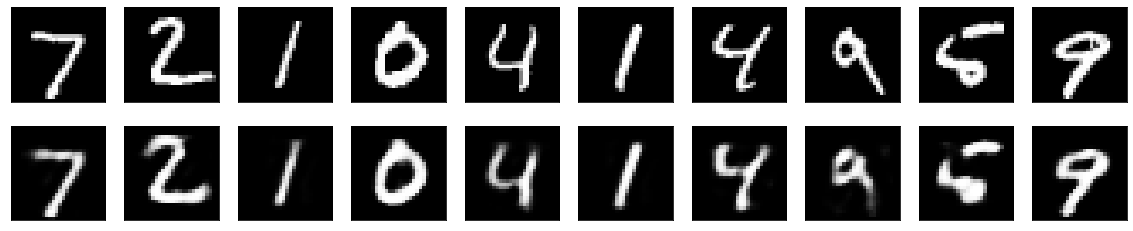

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
